# Homework (9 pts) - Neural Networks

**!!! Plus 3 pts EXTRA CREDIT**

Mouse V1 data from Stringer et al. (2019)
https://www.biorxiv.org/content/10.1101/679324v2.abstract

These data comprise time-averaged responses of ~20,000 neurons to ~4,000 stimulus gratings of different orientations from 0-360 degrees, recorded through Calcium imaging. The responses have been normalized by spontaneous levels of activity and then z-scored over stimuli, so expect negative numbers. They have also been binned and averaged to each degree of orientation.

In [1]:
import numpy as np

# if you put these files somewher else just edit the paths
neural_responses = np.load('../lectures/30 - neural networks/neural_responses.npy')
grating_orientations = np.load('../lectures/30 - neural networks/grating_orientations.npy')

# angle normalized to fall in [0,1]
# to get back actual angle, just multiply by 360
grating_orientations /= 360

neural_responses.shape, grating_orientations.shape

((360, 23589), (360,))

---
1. (3 pts) Set the variable `device` to either "cuda" or "cpu" as appropriate.

In [2]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

---
2. (3 pts) Split data into training and testing sets with 50% of the data in each set. Then convert the data into PyTorch tensors on the appropriate device.

In [3]:
from sklearn.model_selection import train_test_split

X = neural_responses
y = grating_orientations
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.5, random_state=3)

X_train = torch.tensor(X_train).float().to(device)
y_train = torch.tensor(y_train.reshape([-1,1])).float().to(device)

X_test = torch.tensor(X_test).float().to(device)
y_test = torch.tensor(y_test.reshape([-1,1])).float().to(device)

---
3. (3 pts) Define a neural network for predicting grating angle based on neural activity. Input is the activity of all biological neurons. Next layer has 500 neurons with ReLU activation. Next layer has 10 neurons with ReLU activation. Next layer has 5 neurons with ReLU activation. Final layer has as many neurons as needed for the task with sigmoid activation.

In [29]:
from torch import nn

class NNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(23589, 500)
        self.linear2 = nn.Linear(500, 10)
        self.linear3 = nn.Linear(10, 5)
        self.linear4 = nn.Linear(5, 1)

    def forward(self, X):
        X = torch.relu(self.linear1(X))
        X = torch.relu(self.linear2(X))
        X = torch.relu(self.linear3(X))
        y = torch.sigmoid(self.linear4(X))
        return y

---
EXTRA CREDIT (1 pt) Write function for training your network.

In [30]:
def train(model, X, y, loss_fn, optimizer, n_epochs):
    # put model into training mode
    model.train()
    
    train_loss = np.zeros(n_epochs)
    for i in range(n_epochs):
        # Compute prediction error
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # update model parameters (i.e., weights and biases)
        optimizer.step()
        
        # store loss
        train_loss[i] = loss.item()
    
    return train_loss

---
EXTRA CREDIT (1 pt) Create an instance of your neural network on the appropriate device, a loss function, a stochastic gradient descent optimizer (try a learning rate of ~0.1), and then train your network with enough epochs to converge.

In [31]:
torch.manual_seed(1)

nnet = NNet().to(device)

loss_fn = nn.MSELoss()

optimizer = torch.optim.SGD(nnet.parameters(), lr=0.1)

train_loss = np.array([])

In [32]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [8, 6]

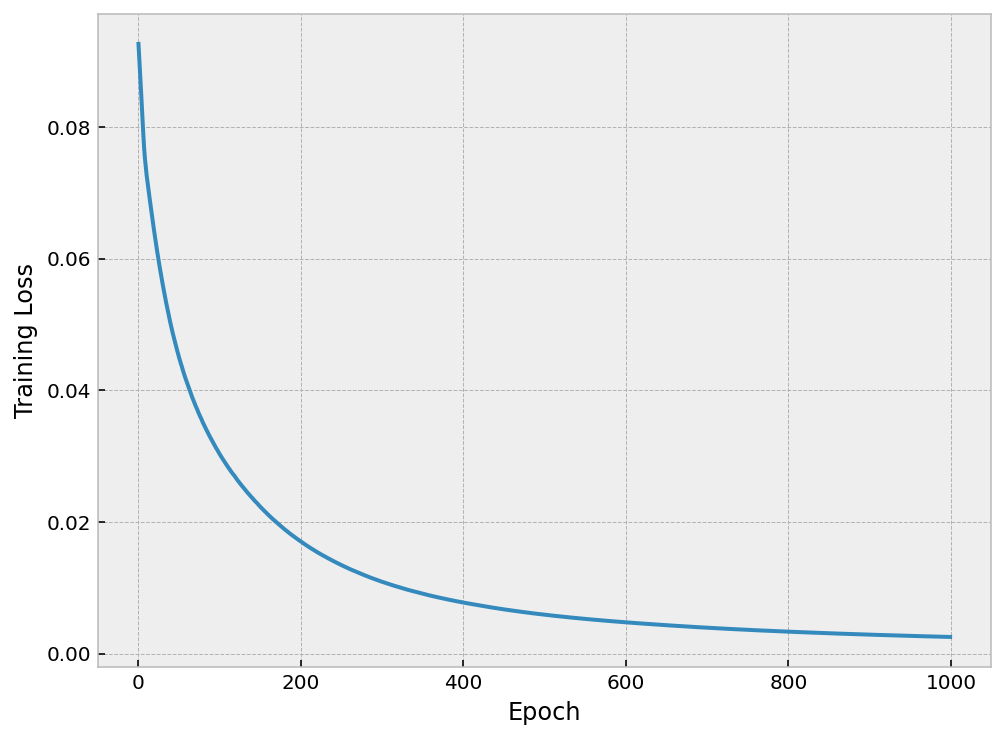

In [34]:
# run this cell as many times as needed

new_train_loss = train(nnet, X_train, y_train, loss_fn, optimizer, 500)

train_loss = np.append(train_loss, new_train_loss)

plt.plot(train_loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss');

---
EXTRA CREDIT (1 pt) Plot the known grating angles in the test set vs. the network's predictions.

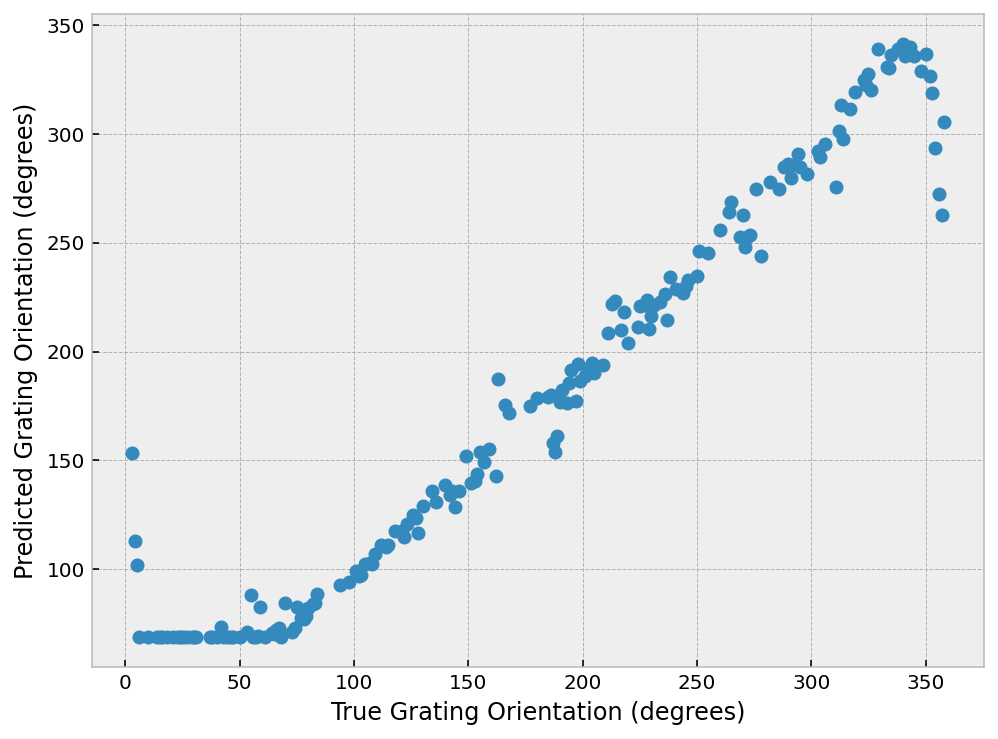

In [35]:
y_out = nnet(X_test)

y_true = y_test.squeeze().detach().numpy() * 360
y_pred = y_out.squeeze().detach().numpy() * 360

plt.plot(y_true, y_pred, 'o')
plt.xlabel('True Grating Orientation (degrees)')
plt.ylabel('Predicted Grating Orientation (degrees)');